In [1]:
import ssms
from ssms.config import model_config as model_config
from ssms.basic_simulators.simulator import simulator
import numpy as np
import pandas as pd
from copy import deepcopy
import pickle
from pathlib import Path

## Define Generator Class

In [2]:
class SSMDataGenerator:
    """A class to generate data from Sequential Sampling Models (SSM).
    
    This class handles the generation of simulated data from various sequential sampling models,
    including parameter sampling and trial generation across multiple subjects.
    
    Parameters
    ----------
    model : str
        The name of the sequential sampling model to use
    n_participants : int
        Number of subjects to simulate
    n_trials : int
        Number of trials per subject
        
    Attributes
    ----------
    model : str
        The name of the sequential sampling model
    model_config : dict
        Configuration dictionary for the specified model
    model_params : list
        List of parameter names for the model
    n_participants : int
        Number of subjects
    n_trials : int
        Number of trials per subject
    param_buffer : float
        Buffer to constrain parameters away from bounds
    param_std_range_fraction : float
        Fraction of parameter range to use for standard deviation
    df : pandas.DataFrame or None
        DataFrame containing generated data
    group_params : dict
        Dictionary of group-level parameters
    subject_params : dict
        Dictionary of subject-level parameters
    state : dict
        Dictionary tracking simulation state
    """
    def __init__(self,
                 model,
                 n_participants: int, 
                 n_trials: int) -> None:
        
        self.model = model
        self.model_config = deepcopy(ssms.config.model_config[model])
        self.model_params = self.model_config["params"]
        
        self.n_participants = n_participants
        self.n_trials = n_trials

        # Parameter constraints
        self.param_buffer = 0.05
        self.param_std_range_fraction = 1/9
        self.continuous_regression_beta_mean_bounds = [-0.5, 0.5]

        # Supplied parameters
        self.group_params_supplied = {}
        self.subject_params_supplied = {}

        # Data
        self.df = None
        self.group_params = {}
        self.subject_params = {}
        self.state = {"sampled": False,
                      "injected_sequential_dynamics": False}

        # RL Rules
        self.basic_rl_config = {"learnable_model_param": "v",
                                "params": ["rl_scaler", "rl_alpha"],
                                "param_bounds": [[2.0, 0.0], [5.0, 1.0]],
                                }
        self.basic_rl_params = self.basic_rl_config["params"]
        self.basic_rl_env = {"ch0_mean": 0.2,
                             "ch0_std": 0.1,
                             "ch1_mean": 0.8,
                             "ch1_std": 0.1
                             }
        
    
    def get_parameter_constraints(self,
                                  target_parameter: str,
                                  model_config: dict | None = None,
                                  param_buffer: float | None = None) -> tuple[list[float], float, float]:
        """Get parameter constraints for a given model parameter.

        Parameters
        ----------
        target_parameter : str
            Name of the parameter to get constraints for

        Returns
        -------
        param_bounds_buffered : list[float]
            Lower and upper bounds for the parameter with buffer applied
        param_bounds_range : float
            Range between buffered bounds
        param_bounds_std_max : float 
            Maximum allowed standard deviation for the parameter
        """

        if model_config is None:
            model_config = self.model_config
        if param_buffer is None:
            param_buffer = self.param_buffer

        param_bounds = [model_config["param_bounds"][0][model_config["params"].index(target_parameter)],
                        model_config["param_bounds"][1][model_config["params"].index(target_parameter)]]
        
        param_bounds_buffered = [0] * 2
        param_bounds_buffered[0] = param_bounds[0] + param_buffer
        param_bounds_buffered[1] = param_bounds[1] - param_buffer
        param_bounds_range = param_bounds_buffered[1] - param_bounds_buffered[0]
        param_bounds_std_max = param_bounds_range * self.param_std_range_fraction

        return param_bounds_buffered, param_bounds_range, param_bounds_std_max
    
    def get_parameter_constraints_vec(self,
                                      model_config: dict | None = None,
                                      param_buffer: float | None = None) -> tuple[list[float], np.ndarray, np.ndarray]:
        """Get parameter constraints vectors for all parameters of a given model.

        Returns
        -------
        param_bounds_buffered : list[float]
            Lower and upper bounds for all parameters with buffer applied
        param_bounds_range : numpy.ndarray
            Range between buffered bounds for all parameters
        param_bounds_std_max : numpy.ndarray
            Maximum allowed standard deviation for all parameters
        """

        if model_config is None:
            model_config = self.model_config
        if param_buffer is None:
            param_buffer = self.param_buffer

        param_bounds = model_config["param_bounds"]
        param_bounds_buffered = deepcopy(param_bounds)
        param_bounds_buffered[0] = np.array(param_bounds)[0] + param_buffer
        param_bounds_buffered[1] = np.array(param_bounds)[1] - param_buffer
        param_bounds_range = param_bounds_buffered[1] - param_bounds_buffered[0]
        param_bounds_std_max = param_bounds_range * self.param_std_range_fraction

        return param_bounds_buffered, param_bounds_range, param_bounds_std_max
    
    def prep_dfs_for_saving(self,
                            first_columns: list = ["response", "rt", "participant_id", "trial"]) -> tuple[pd.DataFrame, pd.DataFrame]:
        """Order columns of DataFrames to match the HSSM standard format and create modeling subset.

        This function reorders the columns of a DataFrame to place specified columns at the beginning,
        followed by parameters, and then by model-specific parameters. It also creates a subset
        DataFrame containing only the columns needed for modeling.

        Parameters
        ----------
        first_columns : list, optional
            List of column names to place at the beginning of the DataFrame, by default ["response", "rt", "participant_id", "trial"]

        Returns
        -------
        tuple[pd.DataFrame, pd.DataFrame]
            - DataFrame with reordered columns including all parameters
            - DataFrame subset containing only modeling-relevant columns
            
        Raises
        ------
        ValueError
            If attempting to get modeling df before sampling data
        """

        if not self.state["sampled"]:
            raise ValueError("Attempt to get modeling df before sampling data")

        df_tmp = deepcopy(self.df)
        columns_ = list(df_tmp.columns)
        first_cols_ = [col for col in first_columns if col in columns_]
        remain_cols_ = [col for col in columns_ if col not in first_cols_]
        columns_hssm = first_cols_ + remain_cols_
        df_ordered = df_tmp[columns_hssm]


        modeling_cols = [col for col in df_ordered.columns if \
                         (("beta" not in col) and (col not in self.model_params)) and ("rl_" not in col)]
        df_modeling = df_ordered[modeling_cols]
        
        return df_ordered, df_modeling

    def inject_trials(self) -> pd.DataFrame:
        """Inject trials into the dataframe by repeating each subject's data n_trials times.
        
        Returns
        -------
        pd.DataFrame
            DataFrame with injected trials, where each subject's data is repeated n_trials times
            and a trial counter is added
        """
        df_tmp = deepcopy(self.df)
        df_repeated = df_tmp.loc[np.repeat(df_tmp.index, 
                                         self.n_trials)].\
                                          reset_index(drop = True)
        df_repeated["trial"] = df_repeated.groupby("participant_id").cumcount() + 1

        print("Adding trials to attached df")
        self.df = df_repeated
        return df_repeated

    def attach_simulations_to_df(self) -> pd.DataFrame:
        """Attach simulated response times and choices to the dataframe.

        Returns
        -------
        pd.DataFrame
            DataFrame with simulated response times and choices attached

        Raises
        ------
        ValueError
            If attempting to resample when sequential dynamics have been injected
        """
        if self.state["sampled"] and self.state["injected_sequential_dynamics"]:
            raise ValueError("Disallowing resampling because sequential dynamics (e.g. past dependence) have been injected"
                             "This is to ensure that the injected dynamics are not overriden by the resampling.")

        df_tmp = deepcopy(self.df)
        sim_out = simulator(model = self.model, theta = df_tmp[self.model_params], n_samples = 1)
        df_tmp["rt"] = sim_out["rts"].squeeze()
        df_tmp["response"] = sim_out["choices"].squeeze()

        print("Attaching simulations to df")
        self.df = df_tmp
        self.state["sampled"] = True
        return df_tmp

    def get_parameter_sets_hierarchical(self,
                                        include_basic_rl: bool = False) -> tuple[pd.DataFrame, dict, dict]:
        """Generate hierarchical parameter sets for a given model.

        Parameters
        ----------
        include_basic_rl : bool, optional
            Whether to include basic RL parameters, by default False

        Returns
        -------
        pd.DataFrame
            DataFrame containing subject-level parameters and group-level parameters
        dict
            Dictionary containing group-level parameters
        dict
            Dictionary containing subject-level parameters

        Raises
        ------
        ValueError
            If unable to sample parameters within bounds after 100 attempts
        """
        dfs = []
        group_params = {}
        subject_params = {}
        for param in self.model_params:
            param_bounds_buffered, param_bounds_range, param_bounds_std_max = \
                self.get_parameter_constraints(param)
            param_bounds_mean = (param_bounds_buffered[1] + param_bounds_buffered[0]) / 2
            max_mean_perturbation = param_bounds_std_max * 2

            # Sample subject level parameters
            cnt = 0
            while True:
                if f"beta_{param}_intercept_mean" in self.group_params_supplied:
                    group_sample_mean = self.group_params_supplied[f"beta_{param}_intercept_mean"]
                else:
                    # Sample mean perturbation
                    param_bounds_mean_perturbation = np.random.uniform(-max_mean_perturbation, max_mean_perturbation)
                    group_sample_mean = param_bounds_mean + param_bounds_mean_perturbation

                if f"beta_{param}_intercept_std" in self.group_params_supplied:
                    group_sample_std = self.group_params_supplied[f"beta_{param}_intercept_std"]
                else:
                    # Sample std perturbation
                    group_sample_std = np.random.uniform(0.05, np.maximum(0.05, param_bounds_std_max))

                # Subject level parameters
                if f"beta_{param}_intercept_subject" in self.subject_params_supplied:
                    subject_level_parameters = self.subject_params_supplied[f"beta_{param}_intercept_subject"]
                else:
                    subject_level_parameters = np.random.normal(loc = group_sample_mean,
                                                                scale = group_sample_std,
                                                                size=(self.n_participants))
                
                # check if all parameters are within the bounds
                if np.all(subject_level_parameters < (param_bounds_buffered[1])) and \
                    np.all(subject_level_parameters > (param_bounds_buffered[0])):
                    break
                elif cnt > 100:
                    raise ValueError("Failed to sample parameters within bounds after 100 attempts")
                cnt += 1

            df_tmp = pd.DataFrame(subject_level_parameters, columns = [param])
            df_tmp[f"beta_{param}_intercept_mean"] = group_sample_mean
            df_tmp[f"beta_{param}_intercept_std"] = group_sample_std
            df_tmp[f"beta_{param}_intercept_subject"] = subject_level_parameters

            # Update parameter_dicts
            group_params.update({
                f"beta_{param}_intercept_mean": group_sample_mean,
                f"beta_{param}_intercept_std": group_sample_std,
            })
            subject_params.update({
                f"beta_{param}_intercept_subject": subject_level_parameters,
            })
            dfs.append(df_tmp)

        if include_basic_rl:
            for param in self.basic_rl_params:
                param_bounds_buffered, param_bounds_range, param_bounds_std_max = \
                    self.get_parameter_constraints(param,
                                                   model_config = self.basic_rl_config)
                param_bounds_mean = (param_bounds_buffered[1] + param_bounds_buffered[0]) / 2
                max_mean_perturbation = param_bounds_std_max * 2

                # Sample subject level parameters
                cnt = 0
                while True:
                    if f"{param}_group_mean" in self.group_params_supplied:
                        group_sample_mean = self.group_params_supplied[f"{param}_group_mean"]
                    else:
                        # Sample mean perturbation
                        param_bounds_mean_perturbation = np.random.uniform(-max_mean_perturbation, max_mean_perturbation)
                        group_sample_mean = param_bounds_mean + param_bounds_mean_perturbation

                    if f"{param}_group_std" in self.group_params_supplied:
                        group_sample_std = self.group_params_supplied[f"{param}_group_std"]
                    else:
                        # Sample std perturbation
                        group_sample_std = np.random.uniform(0.05, np.maximum(0.05, param_bounds_std_max))

                    # Subject level parameters
                    if f"{param}_subject" in self.subject_params_supplied:
                        subject_level_parameters = self.subject_params_supplied[f"{param}_subject"]
                    else:
                        subject_level_parameters = np.random.normal(loc = group_sample_mean,
                                                                    scale = group_sample_std,
                                                                    size=(self.n_participants))
                    
                    # check if all parameters are within the bounds
                    if np.all(subject_level_parameters < (param_bounds_buffered[1])) and \
                        np.all(subject_level_parameters > (param_bounds_buffered[0])):
                        break
                    elif cnt > 100:
                        raise ValueError("Failed to sample parameters within bounds after 100 attempts")
                    cnt += 1

                df_tmp = pd.DataFrame(subject_level_parameters, columns = [param])
                df_tmp[f"{param}_group_mean"] = group_sample_mean
                df_tmp[f"{param}_group_std"] = group_sample_std
                df_tmp[f"{param}_subject"] = subject_level_parameters

                # Update parameter_dicts
                group_params.update({
                    f"{param}_group_mean": group_sample_mean,
                    f"{param}_group_std": group_sample_std,
                })
                subject_params.update({
                    f"{param}_subject": subject_level_parameters,
                })

                dfs.append(df_tmp)

        df = pd.concat(dfs, axis = 1)
        df = df[self.model_params + df.columns.difference(self.model_params).tolist()]
        df["participant_id"] = np.arange(self.n_participants).astype(str)
        print("Attaching subject level parameters")
        self.df = df

        # Delete the parameter that is learned via rl from parameter dictionaries
        del group_params[f"beta_{self.basic_rl_config['learnable_model_param']}_intercept_mean"]
        del group_params[f"beta_{self.basic_rl_config['learnable_model_param']}_intercept_std"]
        del subject_params[f"beta_{self.basic_rl_config['learnable_model_param']}_intercept_subject"]

        # Update parameter dictionaries
        self.group_params.update(group_params)
        self.subject_params.update(subject_params)
        return self.df, self.group_params, self.subject_params

    def inject_categorical_regression(self,
                                      target_parameter: str,
                                      covariate_name: str = "x",
                                      group_beta_sign: str | None = "positive") -> tuple[pd.DataFrame, dict, dict]:
        """Injects categorical regression effects into parameter values.

        Parameters
        ----------
        df : pd.DataFrame
            DataFrame containing subject and trial data
        model : str
            Name of the model being used
        target_parameter : str
            Parameter to inject categorical effects into
        categorical_name : str, optional
            Name of the categorical variable, by default "x"

        Returns
        -------
        tuple[pd.DataFrame, dict, dict]
            Modified DataFrame, group parameters dict, and subject parameters dict

        Raises
        ------
        ValueError
            If unable to sample parameters within bounds after 100 attempts
        """
        param_bounds_buffered, param_bounds_range, param_bounds_std_max = self.get_parameter_constraints(target_parameter)
        n_participants = len(self.df["participant_id"].unique())
        n_trials = len(self.df["trial"].unique())

        # Inject categorical covariate
        group_params = {}
        subject_params = {}

        cnt = 0
        while True:
            df_tmp = deepcopy(self.df)
            # Add categorical column to dataframe
            df_tmp[f"{covariate_name}"] = np.random.choice([0,1],
                                                             size=(n_participants * n_trials),
                                                             p = [0.5, 0.5])
            
            # Sample group level parameters
            if f"beta_{target_parameter}_{covariate_name}_group_mean" in self.group_params_supplied:
                beta_group_mean = self.group_params_supplied[f"beta_{target_parameter}_{covariate_name}_group_mean"]
            else:
                if group_beta_sign == "positive":
                    beta_group_mean = np.random.uniform(0.1, param_bounds_range * 1/5)
                elif group_beta_sign == "negative":
                    beta_group_mean = np.random.uniform(-(param_bounds_range * 1/5), -0.1)
                else:
                    beta_group_mean = np.random.uniform(-(param_bounds_range * 1/5), 
                                                        (param_bounds_range * 1/5))
            
            if f"beta_{target_parameter}_{covariate_name}_group_std" in self.group_params_supplied:
                beta_group_std = self.group_params_supplied[f"beta_{target_parameter}_{covariate_name}_group_std"]
            else:
                beta_group_std = np.random.uniform(0.05, np.maximum(0.05, param_bounds_std_max))

            if f"beta_{target_parameter}_{covariate_name}_subject" in self.subject_params_supplied:
                beta_subject = self.subject_params_supplied[f"beta_{target_parameter}_{covariate_name}_subject"]
            else:
                beta_subject = np.random.normal(beta_group_mean, beta_group_std, size=n_participants)

            df_tmp[f"beta_{target_parameter}_{covariate_name}_group_mean"] = \
                beta_group_mean
            df_tmp[f"beta_{target_parameter}_{covariate_name}_group_std"] = \
                beta_group_std
            df_tmp[f"beta_{target_parameter}_{covariate_name}_subject"] = \
                beta_subject[df_tmp[f"participant_id"].astype(int)]
            
            df_tmp[target_parameter] = df_tmp[target_parameter] + \
                (beta_subject[df_tmp[f"participant_id"].astype(int)] * df_tmp[f"{covariate_name}"])
            if cnt > 100:
                raise ValueError("Failed to sample parameters within bounds after 100 attempts")
            cnt += 1

            if np.all(df_tmp[target_parameter] < (param_bounds_buffered[1])) and \
                np.all(df_tmp[target_parameter] > (param_bounds_buffered[0])):
                break

        # Update parameter_dicts
        group_params.update({
            f"beta_{target_parameter}_{covariate_name}_group_mean": \
                beta_group_mean,
            f"beta_{target_parameter}_{covariate_name}_group_std": \
                beta_group_std,
        })
        subject_params.update({
            f"beta_{target_parameter}_{covariate_name}_subject": beta_subject
        })
        
        # Update dataframe
        self.df = df_tmp
        self.group_params.update(group_params)
        self.subject_params.update(subject_params)
        return self.df, self.group_params, self.subject_params

    def inject_continuous_regression(self,
                                     target_parameter: str,
                                     covariate_name: str,
                                     group_beta_sign: str | None = "negative") -> tuple[pd.DataFrame, dict, dict]:
        """Injects continuous regression effects into a parameter of choice.
        
        Parameters
        ----------
        df : pd.DataFrame
            DataFrame containing trial-wise data
        model : str
            Name of the model being used
        target_parameter : str
            Parameter to inject regression effects into
        covariate_names : list[str]
            List of names for the continuous covariates to add
        beta_sign : str | None, optional
            Sign of the beta parameter, by default "negative"
            
        Returns
        -------
        df : pd.DataFrame
            DataFrame with added continuous regression effects
        group_params : dict
            Dictionary containing group-level parameters
        subject_params : dict
            Dictionary containing subject-level parameters
        """
        param_bounds_buffered, param_bounds_range, param_bounds_std_max = self.get_parameter_constraints(target_parameter)

        n_participants = len(self.df["participant_id"].unique())
        n_trials = len(self.df["trial"].unique())

        group_params = {}
        subject_params = {}

        cnt = 0
        while True:
            df_tmp = deepcopy(self.df)
            df_tmp[f"continuous_{covariate_name}"] = np.random.normal(-1, 1, size=(n_participants * n_trials))

            # Sample parameters
            if f"beta_{target_parameter}_{covariate_name}_group_mean" in self.group_params_supplied:
                beta_group_mean = self.group_params_supplied[f"beta_{target_parameter}_{covariate_name}_group_mean"]
            else:
                if group_beta_sign == "positive":
                    beta_group_mean = np.random.uniform(0.1, 
                                                    self.continuous_regression_beta_mean_bounds[1])
                elif group_beta_sign == "negative":
                    beta_group_mean = np.random.uniform(self.continuous_regression_beta_mean_bounds[0], 
                                                    -0.1)
                else:
                    beta_group_mean = np.random.uniform(self.continuous_regression_beta_mean_bounds[0], 
                                                        self.continuous_regression_beta_mean_bounds[1])
            
            if f"beta_{target_parameter}_{covariate_name}_group_std" in self.group_params_supplied:
                beta_group_std = self.group_params_supplied[f"beta_{target_parameter}_{covariate_name}_group_std"]
            else:
                beta_group_std = np.random.uniform(0.05, 
                                                    np.minimum(0.25,np.maximum(0.05, 
                                                                                param_bounds_std_max)))
            
            if f"beta_{target_parameter}_{covariate_name}_subject" in self.subject_params_supplied:
                beta_subjects = self.subject_params_supplied[f"beta_{target_parameter}_{covariate_name}_subject"]
            else:
                beta_subjects = np.random.normal(loc = beta_group_mean,
                                                    scale = beta_group_std,
                                                    size = n_participants)

                # Update df
                df_tmp[f"beta_{target_parameter}_{covariate_name}_group_mean"] = beta_group_mean
                df_tmp[f"beta_{target_parameter}_{covariate_name}_group_std"] = beta_group_std
                df_tmp[f"beta_{target_parameter}_{covariate_name}_subject"] = beta_subjects[df_tmp[f"participant_id"].astype(int).values]

            # Compute linear predictor (target_parameter)
            df_tmp[target_parameter] = df_tmp[target_parameter] + \
                (df_tmp[f"beta_{target_parameter}_{covariate_name}_subject"] * df_tmp[f"continuous_{covariate_name}"])
        
            if np.all(df_tmp[target_parameter] < (np.array(param_bounds_buffered[1]))) and \
                      np.all(df_tmp[target_parameter] > (np.array(param_bounds_buffered[0]))):
                break
            
            if cnt > 100:
                raise ValueError("Failed to sample parameters within bounds after 100 attempts")
            cnt += 1

        # Update parameter_dicts
        group_params.update({
            f"beta_{target_parameter}_{covariate_name}_group_mean": beta_group_mean,
            f"beta_{target_parameter}_{covariate_name}_group_std": beta_group_std,
        })
        subject_params.update({
            f"beta_{target_parameter}_{covariate_name}_subject": beta_subjects[df_tmp[f"participant_id"].astype(int).values]
        })

        self.df = df_tmp
        self.group_params.update(group_params)
        self.subject_params.update(subject_params)
        return self.df, self.group_params, self.subject_params

    def inject_sticky_choice(self,
                             target_parameter: str) -> tuple[pd.DataFrame, dict, dict]:
        """Injects trial-by-trial dependencies into a parameter based on previous trial responses.
        
        Parameters
        ----------
        target_parameter : str
            Parameter to inject dependencies into ('v' or 'z')
            
        Returns
        -------
        df_tmp : pd.DataFrame
            DataFrame with injected trial dependencies
        group_params : dict
            Dictionary of group-level parameters
        subject_params : dict
            Dictionary of subject-level parameters
            
        Raises
        ------
        ValueError
            If target_parameter is not 'v' or 'z'
            If parameters cannot be sampled within bounds after 100 attempts
        """
        if target_parameter not in ["v", "z"]:
            raise ValueError("Past dependence conceptually only implemented for drift 'v' or bias 'z': "
                             f" You specified {target_parameter}")
        
        param_bounds_buffered, param_bounds_range, param_bounds_std_max = \
            self.get_parameter_constraints(target_parameter)

        n_participants = len(self.df["participant_id"].unique())
        n_trials = len(self.df["trial"].unique())

        cnt = 0
        group_params = {}
        subject_params = {}
        while True:
            df_tmp = deepcopy(self.df)
            
            if f"beta_sticky_{target_parameter}_group_mean" in self.group_params_supplied:
                beta_sticky_group_mean = self.group_params_supplied[f"beta_sticky_{target_parameter}_group_mean"]
            else:
                beta_sticky_group_mean = np.random.uniform(0.05, param_bounds_std_max)
            
            if f"beta_sticky_{target_parameter}_group_std" in self.group_params_supplied:
                beta_sticky_group_std = self.group_params_supplied[f"beta_sticky_{target_parameter}_group_std"]
            else:
                beta_sticky_group_std = np.random.uniform(0.05,
                                        np.maximum(0.05, param_bounds_std_max / 2))
            
            if f"beta_sticky_{target_parameter}_subject" in self.subject_params_supplied:
                beta_sticky_subjects = self.subject_params_supplied[f"beta_sticky_{target_parameter}_subject"]
            else:
                beta_sticky_subjects = np.random.normal(loc = beta_sticky_group_mean,
                                                      scale = beta_sticky_group_std,
                                                      size = n_participants)
            
            # Update parameter_dicts
            group_params.update({
                f"beta_sticky_{target_parameter}_group_mean": beta_sticky_group_mean,
                f"beta_sticky_{target_parameter}_group_std": beta_sticky_group_std,
            })
            subject_params.update({
                f"beta_sticky_{target_parameter}_subject": beta_sticky_subjects
            })
            
            # Update df
            df_tmp[f"beta_sticky_{target_parameter}_group_mean"] = \
                beta_sticky_group_mean
            df_tmp[f"beta_sticky_{target_parameter}_group_std"] = \
                beta_sticky_group_std
            df_tmp[f"beta_sticky_{target_parameter}_subject"] = \
                beta_sticky_subjects[df_tmp[f"participant_id"].astype(int).values]

            # Compute linear predictor (target_parameter)
            df_tmp["response_l1"] = 0
            df_tmp["response"] = 0
            for i in df_tmp["participant_id"].unique():
                displacement_tmp = 0
                for j in range(1, n_trials + 1, 1):

                    params_tmp = df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), 
                                        self.model_params].to_dict(orient = "records")[0]
                    
                    if j > 1:
                        displacement_tmp = (df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j-1), "response"].values * \
                            df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), f"beta_sticky_{target_parameter}_subject"].values)[0]
                        
                    # Apply displacement
                    params_tmp[f"{target_parameter}"] = params_tmp[f"{target_parameter}"] + displacement_tmp

                    df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), f"{target_parameter}"] = \
                        params_tmp[f"{target_parameter}"]
                    
                    sim_tmp = simulator(model = self.model,
                                        theta = params_tmp,
                                        n_samples = 1)

                    df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), "rt"] = \
                        sim_tmp['rts'].squeeze()
                    df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), "response"] = \
                        sim_tmp['choices'].squeeze()
                    
                    if j > 1:
                        df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), "response_l1"] = \
                            df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j-1), "response"].values
            
            if np.all(df_tmp[f"{target_parameter}"] < (param_bounds_buffered[1])) and \
                  np.all(df_tmp[f"{target_parameter}"] > (param_bounds_buffered[0])):
                break
            else:
                print(f"{target_parameter} is out of bounds, trying again, "
                      f"max {target_parameter} = {df_tmp[f'{target_parameter}'].max()} "
                      f"min {target_parameter} = {df_tmp[f'{target_parameter}'].min()}")
                print(f"allowable range = {param_bounds_buffered[0]} to {param_bounds_buffered[1]}")
            
            if cnt > 5:
                raise ValueError("Failed to sample parameters within bounds after 5 attempts")
            cnt += 1
        
        self.df = df_tmp
        self.group_params.update(group_params)
        self.subject_params.update(subject_params)
        self.state["sampled"] = True
        self.state["injected_sequential_dynamics"] = True
        return self.df, self.group_params, self.subject_params
    
    def inject_basic_rl_process(self):
        """Injects a basic reinforcement learning process into the dataset.

        This method injects a basic reinforcement learning process into the dataset,
        which is a simple two-choice process with a fixed learning rate.
        """

        n_participants = len(self.df["participant_id"].unique())
        n_trials = len(self.df["trial"].unique())

        cnt = 0
        group_params = {}
        subject_params = {}
        while True:
            df_tmp = deepcopy(self.df)
            # Compute linear predictor (target_parameter)
            df_tmp["response"] = 0.
            df_tmp["rt"] = 0.
            df_tmp["feedback"] = 0.
            df_tmp["correct"] = 0
            df_tmp["rl_q_val_m1"] = 0.
            df_tmp["rl_q_val_1"] = 0.

            rl_target_param = self.basic_rl_config["learnable_model_param"]
            for i in df_tmp["participant_id"].unique():
                q_val = np.array([0.5, 0.5])
                for j in range(1, n_trials + 1, 1):
                    # Get trial-parameters
                    params_tmp = df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), 
                                        self.model_params].to_dict(orient = "records")[0]
                    rl_params_tmp = df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), 
                                        self.basic_rl_params].to_dict(orient = "records")[0]
                    
                    # Update drift based on rl-rule
                    params_tmp[rl_target_param] = rl_params_tmp["rl_scaler"] * (q_val[1] - q_val[0])

                    # Update drift in df
                    df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), rl_target_param] = \
                        params_tmp[rl_target_param]
                    
                    # Simulate action and rt
                    sim_tmp = simulator(model = self.model,
                                        theta = params_tmp,
                                        n_samples = 1)
                    
                    
                    # Post-process action
                    ssm_action = sim_tmp["choices"].squeeze()
                    ssm_rt = sim_tmp["rts"].squeeze()

                    if ssm_action == -1:
                        action = 0
                        reward = np.random.normal(self.basic_rl_env['ch0_mean'],
                                                  self.basic_rl_env['ch0_std'])
                    elif ssm_action == 1:
                        action = 1
                        reward = np.random.normal(self.basic_rl_env['ch1_mean'],
                                                  self.basic_rl_env['ch1_std'])
                    else:
                        raise ValueError("ssm_action is not -1 or 1")
                    

                    if self.basic_rl_env['ch0_mean'] > self.basic_rl_env['ch1_mean']:
                        action_correct = 0
                    elif self.basic_rl_env['ch0_mean'] < self.basic_rl_env['ch1_mean']:
                        action_correct = 1
                    else:
                        raise ValueError("ch0_mean and ch1_mean are equal")

                    if action == action_correct:
                        correct = 1
                    else:
                        correct = 0

                    # update q-values
                    q_val[action] += rl_params_tmp["rl_alpha"] * (reward - q_val[action])

                    # Update df
                    df_tmp.loc[(df_tmp["participant_id"] == i) & (df_tmp["trial"] == j), ["response", "rt", "feedback", "correct", "rl_q_val_m1", "rl_q_val_1"]] = \
                        [ssm_action, ssm_rt, reward, correct, q_val[0], q_val[1]]

            # Check that v is whithin bounds
            param_bounds_v_buffered, param_bounds_v_range, param_bounds_v_std_max = \
                                                                self.get_parameter_constraints(rl_target_param)

            if np.all(df_tmp[rl_target_param] < (param_bounds_v_buffered[1])) and \
                  np.all(df_tmp[rl_target_param] > (param_bounds_v_buffered[0])):
                break
            else:
                print(f"{rl_target_param} is out of bounds, trying again, "
                      f"max {rl_target_param} = {df_tmp[rl_target_param].max()} "
                      f"min {rl_target_param} = {df_tmp[rl_target_param].min()}")
                print(f"allowable range = {param_bounds_v_buffered[0]} to {param_bounds_v_buffered[1]}")
            
            if cnt > 5:
                raise ValueError("Failed to sample parameters within bounds after 5 attempts")
            cnt += 1

        self.df = df_tmp
        self.group_params.update(group_params)
        self.subject_params.update(subject_params)
        self.state["sampled"] = True
        self.state["injected_sequential_dynamics"] = True
        return self.df, self.group_params, self.subject_params
    
    def make_simple_hierarchical_dataset(self,
                                         group_parameters_supplied: dict | None = None,
                                         subject_parameters_supplied: dict | None = None) -> tuple[pd.DataFrame, dict, dict]:
        """Generate a simple hierarchical dataset with parameters and simulated trials.
        
        This method creates a hierarchical dataset by first generating parameter sets,
        then injecting trials and attaching simulations.

        Parameters
        ----------
        group_parameters_supplied : dict | None, optional
            Group-level parameters to use for the simulation, by default None
        subject_parameters_supplied : dict | None, optional
            Subject-level parameters to use for the simulation, by default None
        
        Returns
        -------
        pd.DataFrame
            DataFrame containing the hierarchical dataset with parameters and simulated data
        dict
            Dictionary containing group-level parameters
        dict
            Dictionary containing subject-level parameters
        """
        if group_parameters_supplied is not None:
            self.group_params_supplied.update(group_parameters_supplied)
        if subject_parameters_supplied is not None:
            self.subject_params_supplied.update(subject_parameters_supplied)

        _, _, _= self.get_parameter_sets_hierarchical()
        

        _ = self.inject_trials()
        _ = self.attach_simulations_to_df()
        return self.df, self.group_params, self.subject_params
    
    def make_hierarchical_regression_dataset(self,
                                             categorical_target: str | None = "a",
                                             categorical_covariate: str | None = "cost_fail_condition", 
                                             categorical_beta_sign: str | None = "positive",
                                             continuous_target: str | None = "v",
                                             continuous_covariate: str | None = "difficulty",
                                             continuous_beta_sign: str | None = "negative",
                                             group_parameters_supplied: dict | None = None,
                                             subject_parameters_supplied: dict | None = None) -> tuple[pd.DataFrame, dict, dict]:
        """Generate a hierarchical regression dataset with both categorical and continuous covariates.

        Parameters
        ----------
        categorical_target : str or None, optional
            Parameter to be modulated by categorical covariate, by default "a"
        categorical_covariate : str or None, optional
            Name of categorical covariate, by default "cost_fail_condition"
        categorical_beta_sign : str | None, optional
            Sign of the categorical beta parameter, by default "positive"
        continuous_target : str or None, optional
            Parameter to be modulated by continuous covariate, by default "v"
        continuous_covariate : str or None, optional
            Name of continuous covariate, by default "difficulty"
        continuous_beta_sign : str | None, optional
            Sign of the continuous beta parameter, by default "negative"
        group_parameters_supplied : dict | None, optional
            Group-level parameters to use for the simulation, by default None
        subject_parameters_supplied : dict | None, optional
            Subject-level parameters to use for the simulation, by default None

        Returns
        -------
        tuple[pd.DataFrame, dict, dict]
            DataFrame containing the hierarchical dataset with parameters and simulated data,
            Dictionary containing group-level parameters,
            Dictionary containing subject-level parameters

        Raises
        ------
        ValueError
            If categorical_target and continuous_target are the same parameter
        """
        if group_parameters_supplied is not None:
            self.group_params_supplied.update(group_parameters_supplied)
        if subject_parameters_supplied is not None:
            self.subject_params_supplied.update(subject_parameters_supplied)
        
        if (categorical_target is not None) and (continuous_target is not None):
            if categorical_target == continuous_target:
                raise ValueError("categorical_target and continuous_target cannot be the same")
        
        _, _, _ = self.get_parameter_sets_hierarchical()
        _ = self.inject_trials()
        
        if categorical_target is not None:
            _, _, _ = self.inject_categorical_regression(target_parameter = categorical_target,
                                                         covariate_name = categorical_covariate,
                                                         group_beta_sign = categorical_beta_sign)

        if continuous_target is not None:
            _, _, _ = self.inject_continuous_regression(target_parameter = continuous_target,
                                                        covariate_name = continuous_covariate,
                                                        group_beta_sign = continuous_beta_sign)

        _ = self.attach_simulations_to_df()
        return self.df, self.group_params, self.subject_params

    def make_hierarchical_regression_with_sticky_choice(self,
                                                        categorical_target: str | None = "a",
                                                        categorical_covariate: str | None = "cost_fail_condition",
                                                        categorical_beta_sign: str | None = "positive",
                                                        continuous_target: str | None = "v",
                                                        continuous_covariate: str | None = "difficulty",
                                                        continuous_beta_sign: str | None = "negative",
                                                        sticky_target: str = "z",
                                                        group_parameters_supplied: dict | None = None,
                                                        subject_parameters_supplied: dict | None = None) -> tuple[pd.DataFrame, dict, dict]:
        """Generate hierarchical regression data with sticky choice effects.

        Parameters
        ----------
        categorical_target : str or None, optional
            Parameter to apply categorical regression to. Default is "a"
        categorical_covariate : str or None, optional
            Name of categorical covariate. Default is "cost_fail_condition"
        continuous_target : str or None, optional
            Parameter to apply continuous regression to. Default is "v"
        continuous_covariate : str or None, optional
            Name of continuous covariate. Default is "difficulty"
        sticky_target : str, optional
            Parameter to apply sticky choice effects to. Default is "z"
        group_parameters_supplied : dict | None, optional
            Group-level parameters to use for the simulation, by default None
        subject_parameters_supplied : dict | None, optional
            Subject-level parameters to use for the simulation, by default None

        Returns
        -------
        tuple
            Contains:
            - pd.DataFrame: DataFrame with simulated data
            - dict: Group-level parameters
            - dict: Subject-level parameters

        Raises
        ------
        ValueError
            If categorical_target and continuous_target are the same parameter
        """
        if group_parameters_supplied is not None:
            self.group_params_supplied.update(group_parameters_supplied)
        if subject_parameters_supplied is not None:
            self.subject_params_supplied.update(subject_parameters_supplied)

        if (categorical_target is not None) and (continuous_target is not None):
            if categorical_target == continuous_target:
                raise ValueError("categorical_target and continuous_target cannot be the same")
        
        _, _, _ = self.get_parameter_sets_hierarchical()
        _ = self.inject_trials()
        
        if categorical_target is not None:
            _, _, _ = self.inject_categorical_regression(
                                                    target_parameter = categorical_target,
                                                    covariate_name = categorical_covariate,
                                                    group_beta_sign = categorical_beta_sign)
        
        if continuous_target is not None:
            _, _, _ = self.inject_continuous_regression(
                                                   target_parameter = continuous_target,
                                                   covariate_name = continuous_covariate,
                                                   group_beta_sign = continuous_beta_sign)
        
        # Note: This adds simulations to the df
        _, _, _ = self.inject_sticky_choice(target_parameter = sticky_target)

        return self.df, self.group_params, self.subject_params

    def make_rl_dataset(self,
                        group_parameters_supplied: dict | None = None,
                        subject_parameters_supplied: dict | None = None):
        """Generate a dataset for reinforcement learning models.

        This method creates a dataset with simulated data for reinforcement learning models.
        It includes simulated choices and rewards for multiple subjects and trials.

        Returns
        -------
        tuple
            Contains:
            - pd.DataFrame: DataFrame with simulated data
            - dict: Group-level parameters
            - dict: Subject-level parameters
        """

        if group_parameters_supplied is not None:
            self.group_params_supplied.update(group_parameters_supplied)
        if subject_parameters_supplied is not None:
            self.subject_params_supplied.update(subject_parameters_supplied)

        _, _, _ = self.get_parameter_sets_hierarchical(include_basic_rl = True)
        _ = self.inject_trials()
        _, _ , _ = self.inject_basic_rl_process()

        return self.df, self.group_params, self.subject_params

    def save_data(self, 
                  filename_base: str,
                  folder: str = "data") -> None:
        """Save simulation data and parameters to files.

        Parameters
        ----------
        filename_base : str
            Base filename to use for saving files. Will be appended with suffixes.
        folder : str, optional
            Folder to save files in, by default "data"
        columns_for_modeling : list[str] | None, optional
            List of column names to include in modeling dataset, by default None

        Raises
        ------
        ValueError
            If columns_for_modeling is None
        """
        # Make folder via pathlib
        Path(folder).mkdir(parents=True,
                           exist_ok=True)
        
        df_ordered, df_modeling = self.prep_dfs_for_saving()
        
        # Save Full df:
        df_ordered.to_parquet(f"{folder}/{filename_base}_full.parquet",
                           index=False)

        # Save df for modeling:
        df_modeling.to_parquet(f"{folder}/{filename_base}_modeling.parquet",
                               index=False)
        
        # Save the parameter dicts as one dict via pickle
        with open(f"{folder}/{filename_base}_parameters.pkl", "wb") as f:
            pickle.dump({"group_params": self.group_params,
                         "subject_params": self.subject_params},
                         f)

    @classmethod
    def load_data(cls, 
                  filename_base: str,
                  folder: str = "data") -> tuple[pd.DataFrame, pd.DataFrame, dict]:
        """Load saved simulation data and parameters from files.

        Parameters
        ----------
        filename_base : str
            Base filename used when saving files
        folder : str, optional
            Folder containing saved files, by default "data"

        Returns
        -------
        tuple[pd.DataFrame, pd.DataFrame, dict]
            Contains:
            - DataFrame with modeling data
            - DataFrame with full data  
            - Dict containing group and subject parameters
        """
        with open(f"{folder}/{filename_base}_parameters.pkl", "rb") as f:
            parameters = pickle.load(f)
        
        df_modeling = pd.read_parquet(f"{folder}/{filename_base}_modeling.parquet")
        df_ordered = pd.read_parquet(f"{folder}/{filename_base}_full.parquet")
        return df_ordered, df_modeling, parameters

In [3]:
SAVE_DATA = False
LOAD_DATA = True

## Basic Model

In [4]:
# Define a few parameters to ensure dataset is somewhat interesting
basic_ddm_group_params = {"beta_t_intercept_mean": 0.3, # Realistic non-decision time
                          "beta_t_intercept_std": 0.075,
                          "beta_a_intercept_mean": 1.25, # Induce some choice variety
                          "beta_a_intercept_std": 0.15,
                          }

In [5]:
BasicDDMGenerator = SSMDataGenerator(model = "ddm",
                                     n_participants = 10,
                                     n_trials = 200)
basic_ddm_df, basic_ddm_group_params, basic_ddm_subject_params = \
    BasicDDMGenerator.make_simple_hierarchical_dataset(group_parameters_supplied = basic_ddm_group_params)

Attaching subject level parameters
Adding trials to attached df
Attaching simulations to df


In [6]:
if SAVE_DATA:
    BasicDDMGenerator.save_data(filename_base = "basic_ddm",
                                folder = "data/basic_ddm_data/")

In [7]:
basic_ddm_group_params

{'beta_a_intercept_mean': 1.25,
 'beta_a_intercept_std': 0.15,
 'beta_z_intercept_mean': 0.6495223704231097,
 'beta_z_intercept_std': 0.05692983100676352,
 'beta_t_intercept_mean': 0.3,
 'beta_t_intercept_std': 0.075}

In [8]:
basic_ddm_subject_params

{'beta_a_intercept_subject': array([1.26595914, 1.30662629, 1.48277314, 1.59088003, 0.91921665,
        1.07220042, 1.05426842, 1.34993033, 1.02086513, 1.15101994]),
 'beta_z_intercept_subject': array([0.66666859, 0.5542693 , 0.58033354, 0.78367008, 0.66343528,
        0.58528289, 0.77268359, 0.6992469 , 0.57145357, 0.6995834 ]),
 'beta_t_intercept_subject': array([0.34965439, 0.29252735, 0.27856603, 0.28816714, 0.24575337,
        0.31376877, 0.26025306, 0.27999666, 0.31155241, 0.44104174])}

In [9]:
basic_ddm_df

,v,a,z,t,beta_a_intercept_mean,beta_a_intercept_std,beta_a_intercept_subject,beta_t_intercept_mean,beta_t_intercept_std,beta_t_intercept_subject,beta_v_intercept_mean,beta_v_intercept_std,beta_v_intercept_subject,beta_z_intercept_mean,beta_z_intercept_std,beta_z_intercept_subject,participant_id,trial,rt,response
0,0.136975,1.265959,0.666669,0.349654,1.25,0.15,1.265959,0.3,0.075,0.349654,0.312271,0.309859,0.136975,0.649522,0.05693,0.666669,0,1,1.968858,-1
1,0.136975,1.265959,0.666669,0.349654,1.25,0.15,1.265959,0.3,0.075,0.349654,0.312271,0.309859,0.136975,0.649522,0.05693,0.666669,0,2,1.146523,1
2,0.136975,1.265959,0.666669,0.349654,1.25,0.15,1.265959,0.3,0.075,0.349654,0.312271,0.309859,0.136975,0.649522,0.05693,0.666669,0,3,0.441099,1
3,0.136975,1.265959,0.666669,0.349654,1.25,0.15,1.265959,0.3,0.075,0.349654,0.312271,0.309859,0.136975,0.649522,0.05693,0.666669,0,4,2.245727,1
4,0.136975,1.265959,0.666669,0.349654,1.25,0.15,1.265959,0.3,0.075,0.349654,0.312271,0.309859,0.136975,0.649522,0.05693,0.666669,0,5,2.169611,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.210292,1.151020,0.699583,0.441042,1.25,0.15,1.151020,0.3,0.075,0.441042,0.312271,0.309859,0.210292,0.649522,0.05693,0.699583,9,196,0.751351,-1
1996,0.210292,1.151020,0.699583,0.441042,1.25,0.15,1.151020,0.3,0.075,0.441042,0.312271,0.309859,0.210292,0.649522,0.05693,0.699583,9,197,0.634951,1
1997,0.210292,1.151020,0.699583,0.441042,1.25,0.15,1.151020,0.3,0.075,0.441042,0.312271,0.309859,0.210292,0.649522,0.05693,0.699583,9,198,1.042200,1
1998,0.210292,1.151020,0.699583,0.441042,1.25,0.15,1.151020,0.3,0.075,0.441042,0.312271,0.309859,0.210292,0.649522,0.05693,0.699583,9,199,1.816312,-1


In [10]:
if LOAD_DATA:
    df_basic_ddm_modeling, df_basic_ddm_ordered, basic_ddm_parameter_dict = \
        SSMDataGenerator.load_data(filename_base = "basic_ddm",
                                folder = "data/basic_ddm_data/")

## Basic Model Angle

In [11]:
# Define a few parameters to ensure dataset is somewhat interesting
basic_angle_group_params = {"beta_theta_intercept_mean": 0.4, # Allow mistakes even with higher drift
                            "beta_theta_intercept_std": 0.075,
                            "beta_t_intercept_mean": 0.3, # Realistic non-decision time
                            "beta_t_intercept_std": 0.075,
                            }

In [12]:
BasicAngleGenerator = SSMDataGenerator(model = "angle", 
                                       n_participants = 10, 
                                       n_trials = 200)
basic_angle_df, basic_angle_group_params, basic_angle_subject_params = \
    BasicAngleGenerator.make_simple_hierarchical_dataset(group_parameters_supplied = basic_angle_group_params)

Attaching subject level parameters
Adding trials to attached df
Attaching simulations to df


In [13]:
if SAVE_DATA:
    BasicAngleGenerator.save_data(filename_base = "basic_angle",
                                folder = "data/basic_angle_data/")

In [14]:
basic_angle_df

,v,a,z,t,theta,beta_a_intercept_mean,beta_a_intercept_std,beta_a_intercept_subject,beta_t_intercept_mean,beta_t_intercept_std,...,beta_v_intercept_mean,beta_v_intercept_std,beta_v_intercept_subject,beta_z_intercept_mean,beta_z_intercept_std,beta_z_intercept_subject,participant_id,trial,rt,response
0,0.946325,1.608610,0.458683,0.118969,0.476897,1.754335,0.145121,1.608610,0.3,0.075,...,0.446663,0.63994,0.946325,0.405051,0.071268,0.458683,0,1,1.170234,1
1,0.946325,1.608610,0.458683,0.118969,0.476897,1.754335,0.145121,1.608610,0.3,0.075,...,0.446663,0.63994,0.946325,0.405051,0.071268,0.458683,0,2,2.059524,1
2,0.946325,1.608610,0.458683,0.118969,0.476897,1.754335,0.145121,1.608610,0.3,0.075,...,0.446663,0.63994,0.946325,0.405051,0.071268,0.458683,0,3,0.650266,1
3,0.946325,1.608610,0.458683,0.118969,0.476897,1.754335,0.145121,1.608610,0.3,0.075,...,0.446663,0.63994,0.946325,0.405051,0.071268,0.458683,0,4,0.516642,1
4,0.946325,1.608610,0.458683,0.118969,0.476897,1.754335,0.145121,1.608610,0.3,0.075,...,0.446663,0.63994,0.946325,0.405051,0.071268,0.458683,0,5,1.607036,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.900512,1.596415,0.502749,0.250614,0.391707,1.754335,0.145121,1.596415,0.3,0.075,...,0.446663,0.63994,0.900512,0.405051,0.071268,0.502749,9,196,1.657925,1
1996,0.900512,1.596415,0.502749,0.250614,0.391707,1.754335,0.145121,1.596415,0.3,0.075,...,0.446663,0.63994,0.900512,0.405051,0.071268,0.502749,9,197,1.146349,1
1997,0.900512,1.596415,0.502749,0.250614,0.391707,1.754335,0.145121,1.596415,0.3,0.075,...,0.446663,0.63994,0.900512,0.405051,0.071268,0.502749,9,198,0.630775,1
1998,0.900512,1.596415,0.502749,0.250614,0.391707,1.754335,0.145121,1.596415,0.3,0.075,...,0.446663,0.63994,0.900512,0.405051,0.071268,0.502749,9,199,0.724296,-1


In [15]:
basic_angle_group_params

{'beta_a_intercept_mean': 1.7543349141080113,
 'beta_a_intercept_std': 0.14512116600962063,
 'beta_z_intercept_mean': 0.40505113919558033,
 'beta_z_intercept_std': 0.0712680501203053,
 'beta_t_intercept_mean': 0.3,
 'beta_t_intercept_std': 0.075,
 'beta_theta_intercept_mean': 0.4,
 'beta_theta_intercept_std': 0.075}

In [16]:
basic_angle_subject_params

{'beta_a_intercept_subject': array([1.6086097 , 1.48849596, 1.906999  , 1.87955335, 2.12405568,
        2.02605896, 1.97213148, 1.89570975, 1.47406527, 1.59641469]),
 'beta_z_intercept_subject': array([0.45868279, 0.37685288, 0.4951891 , 0.34072146, 0.34240131,
        0.3235531 , 0.46816694, 0.48222426, 0.4058165 , 0.50274906]),
 'beta_t_intercept_subject': array([0.11896876, 0.15919509, 0.27037179, 0.20204964, 0.27120861,
        0.28883088, 0.25416488, 0.15315919, 0.1445698 , 0.25061414]),
 'beta_theta_intercept_subject': array([0.47689726, 0.36950906, 0.47095682, 0.39465675, 0.40285043,
        0.38981015, 0.4679189 , 0.35760244, 0.35061952, 0.3917075 ])}

In [17]:
if LOAD_DATA:
    df_basic_angle_modeling, df_basic_angle_ordered, basic_angle_parameter_dict = \
        BasicAngleGenerator.load_data(filename_base = "basic_angle",
                                    folder = "data/basic_angle_data/")

## Basic Model Angle Regression

In [18]:
# Define a few parameters to ensure dataset is somewhat interesting
basic_angle_group_params = {"beta_theta_intercept_mean": 0.4, # Allow mistakes even with higher drift
                            "beta_theta_intercept_std": 0.075,
                            "beta_t_intercept_mean": 0.3, # Realistic non-decision time
                            "beta_t_intercept_std": 0.075,
                            }

In [19]:
BasicAngleRegressionGenerator = SSMDataGenerator(model = "angle", 
                                                 n_participants = 10,
                                                 n_trials = 500)
basic_angle_regression_df, basic_angle_regression_group_params, basic_angle_regression_subject_params = \
    BasicAngleRegressionGenerator.make_hierarchical_regression_dataset(categorical_target = "a",
                                                                       categorical_covariate = "costly_fail_condition",
                                                                       categorical_beta_sign = "positive",
                                                                       continuous_target = "v",
                                                                       continuous_covariate = "difficulty",
                                                                       continuous_beta_sign = "negative",
                                                                       group_parameters_supplied = basic_angle_group_params)

Attaching subject level parameters
Adding trials to attached df
Attaching simulations to df


In [20]:
if SAVE_DATA:
    BasicAngleRegressionGenerator.save_data(filename_base = "angle_regression",
                                            folder = "data/angle_regression_data/")

In [21]:
basic_angle_regression_group_params

{'beta_a_intercept_mean': 1.8792064487250593,
 'beta_a_intercept_std': 0.17404534356624046,
 'beta_z_intercept_mean': 0.4250959641705948,
 'beta_z_intercept_std': 0.05383788837787964,
 'beta_t_intercept_mean': 0.3,
 'beta_t_intercept_std': 0.075,
 'beta_theta_intercept_mean': 0.4,
 'beta_theta_intercept_std': 0.075,
 'beta_a_costly_fail_condition_group_mean': 0.1527422285441566,
 'beta_a_costly_fail_condition_group_std': 0.16279398877740714,
 'beta_v_difficulty_group_mean': -0.42779974780295593,
 'beta_v_difficulty_group_std': 0.18887442057230774}

In [22]:
basic_angle_regression_subject_params

{'beta_a_intercept_subject': array([1.78559219, 2.01431422, 1.8153963 , 1.74320322, 1.93961007,
        1.77089073, 1.91987161, 1.67946932, 1.6174957 , 1.71066835]),
 'beta_z_intercept_subject': array([0.3859618 , 0.54798574, 0.42904862, 0.43148009, 0.46113236,
        0.38877644, 0.49127185, 0.40275351, 0.42313167, 0.4158181 ]),
 'beta_t_intercept_subject': array([0.20085551, 0.31258376, 0.30267185, 0.3878793 , 0.15768289,
        0.15180329, 0.31847493, 0.22710827, 0.27909939, 0.25458578]),
 'beta_theta_intercept_subject': array([0.42458477, 0.36909609, 0.37219914, 0.39416049, 0.38106862,
        0.3947819 , 0.51948617, 0.27651607, 0.35271009, 0.4512023 ]),
 'beta_a_costly_fail_condition_subject': array([ 0.43437195,  0.26865429,  0.17318927,  0.07062479,  0.00939   ,
         0.26179902,  0.08580012, -0.05669968,  0.11758353, -0.02973569]),
 'beta_v_difficulty_subject': array([-0.36434895, -0.36434895, -0.36434895, ..., -0.51277559,
        -0.51277559, -0.51277559], shape=(5000,))}

In [23]:
basic_angle_regression_df

,v,a,z,t,theta,beta_a_intercept_mean,beta_a_intercept_std,beta_a_intercept_subject,beta_t_intercept_mean,beta_t_intercept_std,...,costly_fail_condition,beta_a_costly_fail_condition_group_mean,beta_a_costly_fail_condition_group_std,beta_a_costly_fail_condition_subject,continuous_difficulty,beta_v_difficulty_group_mean,beta_v_difficulty_group_std,beta_v_difficulty_subject,rt,response
0,-0.513807,2.219964,0.385962,0.200856,0.424585,1.879206,0.174045,1.785592,0.3,0.075,...,1,0.152742,0.162794,0.434372,-1.025937,-0.4278,0.188874,-0.364349,2.064190,-1
1,-0.136060,2.219964,0.385962,0.200856,0.424585,1.879206,0.174045,1.785592,0.3,0.075,...,1,0.152742,0.162794,0.434372,-2.062710,-0.4278,0.188874,-0.364349,1.141374,-1
2,-0.868558,1.785592,0.385962,0.200856,0.424585,1.879206,0.174045,1.785592,0.3,0.075,...,0,0.152742,0.162794,0.434372,-0.052280,-0.4278,0.188874,-0.364349,1.163182,-1
3,-0.773217,1.785592,0.385962,0.200856,0.424585,1.879206,0.174045,1.785592,0.3,0.075,...,0,0.152742,0.162794,0.434372,-0.313956,-0.4278,0.188874,-0.364349,0.523167,-1
4,0.044772,1.785592,0.385962,0.200856,0.424585,1.879206,0.174045,1.785592,0.3,0.075,...,0,0.152742,0.162794,0.434372,-2.559025,-0.4278,0.188874,-0.364349,1.136899,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.947917,1.680933,0.415818,0.254586,0.451202,1.879206,0.174045,1.710668,0.3,0.075,...,1,0.152742,0.162794,-0.029736,0.459858,-0.4278,0.188874,-0.512776,0.852663,-1
4996,-0.521196,1.680933,0.415818,0.254586,0.451202,1.879206,0.174045,1.710668,0.3,0.075,...,1,0.152742,0.162794,-0.029736,-2.322493,-0.4278,0.188874,-0.512776,0.654988,-1
4997,-0.952956,1.710668,0.415818,0.254586,0.451202,1.879206,0.174045,1.710668,0.3,0.075,...,0,0.152742,0.162794,-0.029736,-1.480485,-0.4278,0.188874,-0.512776,1.273868,-1
4998,-0.207706,1.680933,0.415818,0.254586,0.451202,1.879206,0.174045,1.710668,0.3,0.075,...,1,0.152742,0.162794,-0.029736,-2.933851,-0.4278,0.188874,-0.512776,0.710858,-1


In [24]:
if LOAD_DATA:
    angle_regression_full, angle_regression_modeling, angle_regression_parameters = \
                                    BasicAngleRegressionGenerator.load_data(filename_base = "angle_regression",
                                                                        folder = "data/angle_regression_data/")

## Basic Model Angle Regression Past Dependence

In [25]:
# Define a few parameters to ensure dataset is somewhat interesting
angle_sticky_choice_group_params = {"beta_theta_intercept_mean": 0.4, # Allow mistakes even with higher drift
                            "beta_theta_intercept_std": 0.075,
                            "beta_a_intercept_mean": 1.25, # Induce some choice variety
                            "beta_a_intercept_std": 0.15,
                            "beta_t_intercept_mean": 0.3, # Realistic non-decision time
                            "beta_t_intercept_std": 0.075,
                            }

In [26]:
AngleStickyChoice = SSMDataGenerator(model = "angle",
                                     n_participants = 10,
                                     n_trials = 500)

angle_sticky_choice_df, angle_sticky_choice_group_params, angle_sticky_choice_subject_params = \
    AngleStickyChoice.make_hierarchical_regression_with_sticky_choice(categorical_target = "a",
                                                                      categorical_covariate = "costly_fail_condition",
                                                                      continuous_target = "v",
                                                                      continuous_covariate = "difficulty",
                                                                      sticky_target = "z",
                                                                      group_parameters_supplied = angle_sticky_choice_group_params)

Attaching subject level parameters
Adding trials to attached df


In [27]:
angle_sticky_choice_df

,v,a,z,t,theta,beta_a_intercept_mean,beta_a_intercept_std,beta_a_intercept_subject,beta_t_intercept_mean,beta_t_intercept_std,...,continuous_difficulty,beta_v_difficulty_group_mean,beta_v_difficulty_group_std,beta_v_difficulty_subject,beta_sticky_z_group_mean,beta_sticky_z_group_std,beta_sticky_z_subject,response_l1,response,rt
0,1.234845,1.225130,0.473310,0.303995,0.332782,1.25,0.15,1.22513,0.3,0.075,...,-1.882674,-0.120003,0.146617,-0.168304,0.062963,0.05,0.018172,0,1,1.939386
1,1.068523,1.435871,0.491483,0.303995,0.332782,1.25,0.15,1.22513,0.3,0.075,...,-0.894450,-0.120003,0.146617,-0.168304,0.062963,0.05,0.018172,1,1,1.668716
2,0.820813,1.225130,0.491483,0.303995,0.332782,1.25,0.15,1.22513,0.3,0.075,...,0.577354,-0.120003,0.146617,-0.168304,0.062963,0.05,0.018172,1,1,0.587910
3,1.294305,1.225130,0.491483,0.303995,0.332782,1.25,0.15,1.22513,0.3,0.075,...,-2.235961,-0.120003,0.146617,-0.168304,0.062963,0.05,0.018172,1,1,1.582239
4,1.240912,1.225130,0.491483,0.303995,0.332782,1.25,0.15,1.22513,0.3,0.075,...,-1.918717,-0.120003,0.146617,-0.168304,0.062963,0.05,0.018172,1,1,1.093758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.177541,1.527483,0.375657,0.253587,0.403915,1.25,0.15,1.33477,0.3,0.075,...,-0.649259,-0.120003,0.146617,-0.189902,0.062963,0.05,0.091987,1,1,1.662095
4996,1.240692,1.527483,0.375657,0.253587,0.403915,1.25,0.15,1.33477,0.3,0.075,...,-0.981806,-0.120003,0.146617,-0.189902,0.062963,0.05,0.091987,1,1,0.778051
4997,1.216256,1.527483,0.375657,0.253587,0.403915,1.25,0.15,1.33477,0.3,0.075,...,-0.853129,-0.120003,0.146617,-0.189902,0.062963,0.05,0.091987,1,1,0.734184
4998,0.927771,1.334770,0.375657,0.253587,0.403915,1.25,0.15,1.33477,0.3,0.075,...,0.666000,-0.120003,0.146617,-0.189902,0.062963,0.05,0.091987,1,-1,1.368040


In [28]:
if SAVE_DATA:
    AngleStickyChoice.save_data(filename_base = "angle_sticky_choice",
                                folder = "data/angle_sticky_choice_data/")

In [29]:
angle_sticky_choice_group_params

{'beta_a_intercept_mean': 1.25,
 'beta_a_intercept_std': 0.15,
 'beta_z_intercept_mean': 0.3706962707427705,
 'beta_z_intercept_std': 0.06328816597097917,
 'beta_t_intercept_mean': 0.3,
 'beta_t_intercept_std': 0.075,
 'beta_theta_intercept_mean': 0.4,
 'beta_theta_intercept_std': 0.075,
 'beta_a_costly_fail_condition_group_mean': 0.1343523303369934,
 'beta_a_costly_fail_condition_group_std': 0.13507483901386566,
 'beta_v_difficulty_group_mean': -0.12000316048242972,
 'beta_v_difficulty_group_std': 0.14661732346589204,
 'beta_sticky_z_group_mean': 0.06296313024869941,
 'beta_sticky_z_group_std': 0.05}

In [30]:
angle_sticky_choice_subject_params

{'beta_a_intercept_subject': array([1.22512971, 1.23330252, 1.14052872, 1.18579432, 1.15815556,
        1.55353867, 1.45656874, 1.15904069, 1.23787732, 1.33476955]),
 'beta_z_intercept_subject': array([0.47331029, 0.4395077 , 0.26689555, 0.27341418, 0.34928973,
        0.4422493 , 0.34790427, 0.38515288, 0.35249397, 0.28366984]),
 'beta_t_intercept_subject': array([0.30399456, 0.25918449, 0.45508179, 0.23611522, 0.35401394,
        0.09362679, 0.36187682, 0.23640484, 0.27583959, 0.25358668]),
 'beta_theta_intercept_subject': array([0.33278193, 0.36201726, 0.35862068, 0.43704141, 0.35315769,
        0.45329968, 0.5359086 , 0.37643402, 0.36411687, 0.40391469]),
 'beta_a_costly_fail_condition_subject': array([ 0.21074082, -0.10915026,  0.13118707,  0.15106093,  0.20840843,
         0.31002013, -0.02510268,  0.18448109,  0.23984927,  0.19271303]),
 'beta_v_difficulty_subject': array([-0.16830413, -0.16830413, -0.16830413, ..., -0.18990163,
        -0.18990163, -0.18990163], shape=(5000,)),

In [31]:
if LOAD_DATA:
     angle_sticky_choice_full, angle_sticky_choice_modeling, angle_sticky_choice_parameters = \
        AngleStickyChoice.load_data(filename_base = "angle_sticky_choice",
                                 folder = "data/angle_sticky_choice_data/")

#### Inspect

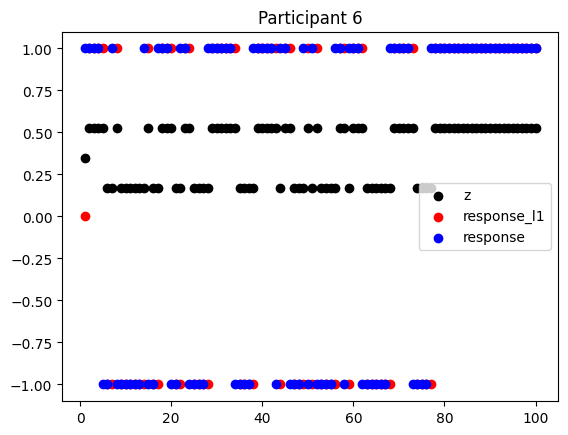

In [32]:
import matplotlib.pyplot as plt
participant_id = str(6)

s1 = angle_sticky_choice_df[(angle_sticky_choice_df['participant_id'] == participant_id) & (angle_sticky_choice_df['trial'] <= 100)]
plt.scatter( s1['trial'], s1['z'], color='black', label='z')
plt.scatter(s1['trial'], s1['response_l1'],  color='red', label='response_l1')
plt.scatter(s1['trial'], s1['response'], color='blue', label='response')
plt.legend()
plt.title(f"Participant {participant_id}")
plt.show()



## RL

In [33]:
# Define a few parameters to ensure dataset is somewhat interesting
rl_angle_group_params = {"beta_a_intercept_mean": 1.25, # Allow mistakes even with higher drift
                         "beta_t_intercept_mean": 0.3, # Realistic non-decision time
                         "beta_t_intercept_std": 0.075,
                         "rl_scaler_group_mean": 2.75, # prevent extremely fast learning
                         }

In [34]:
BasicAngleRL = SSMDataGenerator(model = "angle",
                                n_participants = 20,
                                n_trials = 100)

angle_rl_df, \
    angle_rl_group_params, \
        angle_rl_subject_params = \
    BasicAngleRL.make_rl_dataset(group_parameters_supplied = rl_angle_group_params)

Attaching subject level parameters
Adding trials to attached df


In [35]:
if SAVE_DATA:
    BasicAngleRL.save_data(filename_base = "angle_rl",
                           folder = "data/angle_rl_data/")

In [36]:
if LOAD_DATA:
    angle_rl_full, angle_rl_modeling, angle_rl_parameters = BasicAngleRL.load_data(filename_base = "angle_rl",
                            folder = "data/angle_rl_data/")

#### Plots and Inspection

In [37]:
angle_rl_parameters

{'group_params': {'beta_a_intercept_mean': 1.25,
  'beta_a_intercept_std': 0.2823168856831312,
  'beta_z_intercept_mean': 0.4420901096406401,
  'beta_z_intercept_std': 0.07101875338890874,
  'beta_t_intercept_mean': 0.3,
  'beta_t_intercept_std': 0.075,
  'beta_theta_intercept_mean': 0.8559770336497303,
  'beta_theta_intercept_std': 0.05164160091125088,
  'rl_scaler_group_mean': 2.75,
  'rl_scaler_group_std': 0.20634825057734693,
  'rl_alpha_group_mean': 0.4935267704196423,
  'rl_alpha_group_std': 0.09038962188620488},
 'subject_params': {'beta_a_intercept_subject': array([0.98772935, 1.36519485, 1.33834773, 1.15692216, 1.946748  ,
         1.17252326, 1.01518123, 1.06647518, 1.03007829, 1.0960698 ,
         1.01755343, 1.38329981, 1.24687418, 1.42295107, 1.30541325,
         1.36624896, 0.84817358, 0.6784307 , 1.17016931, 1.30483229]),
  'beta_z_intercept_subject': array([0.34774831, 0.48284028, 0.30228274, 0.29442289, 0.40216921,
         0.44391943, 0.44640059, 0.41972079, 0.4427783

subj:  0  acc:  0.72
subj:  1  acc:  0.91
subj:  2  acc:  0.75
subj:  3  acc:  0.72
subj:  4  acc:  0.9
subj:  5  acc:  0.87
subj:  6  acc:  0.84
subj:  7  acc:  0.82
subj:  8  acc:  0.79
subj:  9  acc:  0.62
subj:  10  acc:  0.87
subj:  11  acc:  0.83
subj:  12  acc:  0.74
subj:  13  acc:  0.9
subj:  14  acc:  0.67
subj:  15  acc:  0.94
subj:  16  acc:  0.78
subj:  17  acc:  0.84
subj:  18  acc:  0.82
subj:  19  acc:  0.72


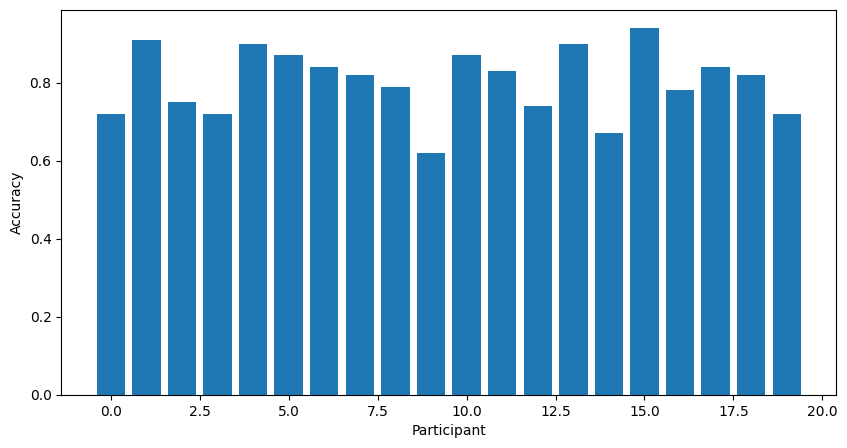

In [38]:
# for every participant, print average accuracy
from matplotlib import pyplot as plt
for subj in range(BasicAngleRL.n_participants):
    print("subj: ", subj, " acc: ", angle_rl_full[angle_rl_full["participant_id"] == str(subj)]["correct"].mean())

# plot accuracy by participant
plt.figure(figsize = (10, 5))
plt.bar(range(BasicAngleRL.n_participants), 
        angle_rl_full["correct"].groupby(angle_rl_full["participant_id"].astype(int)).mean())
plt.xlabel("Participant")
plt.ylabel("Accuracy") 
plt.show()

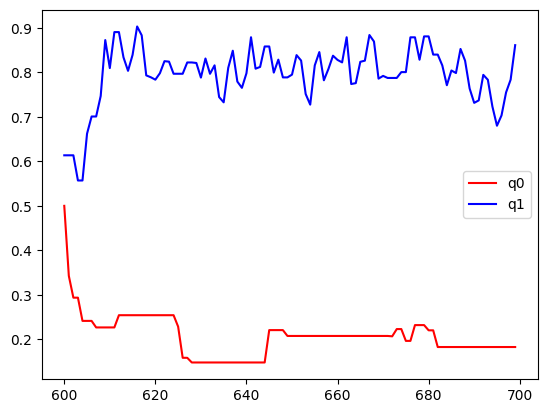

In [39]:
participant_id = str(6)
s1 = angle_rl_full[angle_rl_full['participant_id'] == participant_id]
q0 = s1['rl_q_val_m1']
q1 = s1['rl_q_val_1']

plt.plot(q0, color='red', label='q0')
plt.plot(q1, color='blue', label='q1')
plt.legend()
plt.show()

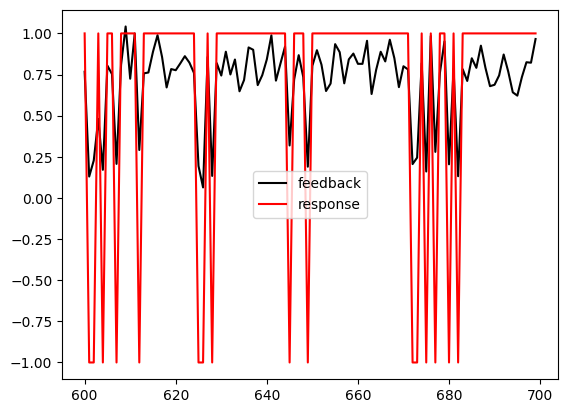

In [40]:
plt.plot(s1['feedback'], color='black', label='feedback')
plt.plot(s1['response'], color='red', label='response')
plt.legend()

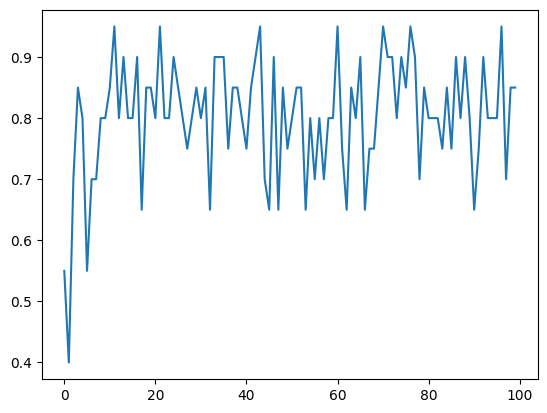

In [41]:
# plot proportion of correct responses
correct = angle_rl_full.groupby('trial')['correct'].mean().values
plt.plot(correct)
plt.show()

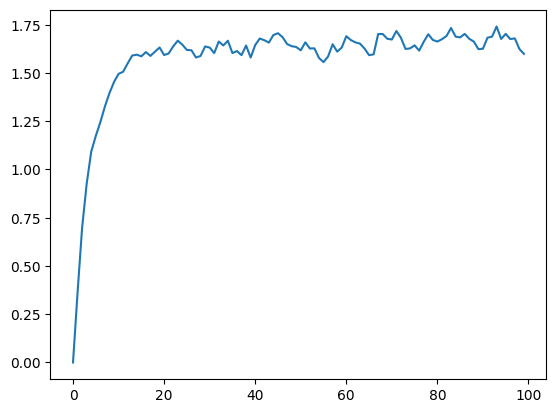

In [42]:
# plot proportion of correct responses
correct = angle_rl_full.groupby('trial')['v'].mean().values
plt.plot(correct)
plt.show()

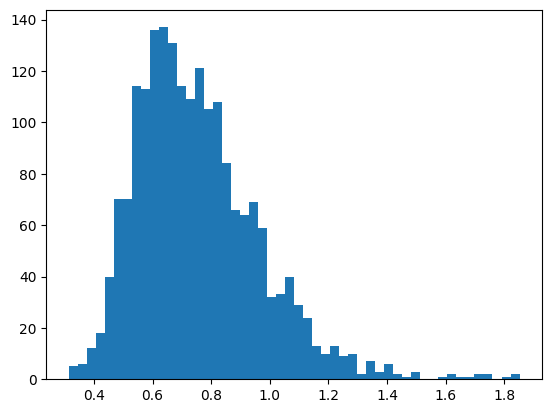

In [43]:
rt_all = angle_rl_full['rt'].values
plt.hist(rt_all, bins=50)
plt.show()
